In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam

2024-11-25 00:24:10.265882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732476250.282989  188858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732476250.288232  188858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 00:24:10.306754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mixed_precision.set_global_policy('mixed_float16')

In [3]:
X=np.load(os.path.join(os.path.dirname(os.getcwd()), 'dataset_prep','all_avg_ratio','avg_ratio_X.npy'))
X.shape

(8666, 20, 8)

In [4]:
y=np.load(os.path.join(os.path.dirname(os.getcwd()), 'dataset_prep','all_avg_ratio','avg_ratio_y.npy'))
y.shape

(8666,)

In [5]:
y=np.reshape(y,(8666,1))
y.shape


(8666, 1)

In [6]:
X.shape

(8666, 20, 8)

In [7]:
train_size=int(0.9*len(X))
val_size=int(0.05*len(X))

In [8]:
# input_dataset = tf.data.Dataset.from_tensor_slices((X))
# output_dataset = tf.data.Dataset.from_tensor_slices((y))

In [9]:
# dataset = tf.data.Dataset.zip((input_dataset, output_dataset))
dataset = tf.data.Dataset.from_tensor_slices((X, y))

I0000 00:00:1732476259.256268  188858 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9565 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:29:00.0, compute capability: 8.6


In [10]:
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=8666>

In [11]:
batch_size = 32

In [12]:
dataset = dataset.shuffle(buffer_size=dataset.cardinality().numpy())

In [13]:
train_dataset=dataset.take(train_size)
val_dataset=dataset.skip(train_size).take(val_size)
test_dataset=dataset.skip(train_size+val_size)

In [14]:
print(f'train_dataset: {train_dataset.cardinality()}, val_dataset: {val_dataset.cardinality()}, test_dataset: {test_dataset.cardinality()}')

train_dataset: 7799, val_dataset: 433, test_dataset: 434


In [15]:
train_dataset = (train_dataset
                 .shuffle(buffer_size=train_dataset.cardinality().numpy())
                 .batch(batch_size=batch_size)
                 .prefetch(tf.data.AUTOTUNE)
                 )

In [16]:
train_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=244>

In [17]:
val_dataset=(val_dataset
             .shuffle(buffer_size=val_dataset.cardinality().numpy())
             .batch(batch_size=batch_size)
             )

In [18]:
test_dataset=(test_dataset
              .shuffle(buffer_size=test_dataset.cardinality().numpy())
                .batch(batch_size=batch_size)
                )

In [19]:
for x_batch, y_batch in train_dataset.take(1):
    input_shape = x_batch.shape[:]  # Extract shape of a single batch's inputs
    print(f"Input shape for the model: {input_shape}")

Input shape for the model: (32, 20, 8)


2024-11-25 00:24:23.438518: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
input_shape

TensorShape([32, 20, 8])

In [21]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[20,8]),
    tf.keras.layers.LSTM(128, activation='tanh',return_sequences=True,dropout=0.2),
    tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True,dropout=0.2 ),
    tf.keras.layers.LSTM(32, activation='tanh',return_sequences=False, ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


In [22]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,001 (515.63 KB)

 Trainable params: 132,001 (515.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 400

In [25]:
history = model.fit(
    train_dataset,  
    validation_data=val_dataset, 
    epochs=epochs
)

Epoch 1/400


I0000 00:00:1732460968.318321   34798 cuda_dnn.cc:529] Loaded cuDNN version 90300


244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.9573 - mean_squared_error: 0.9572 - val_loss: 0.6820 - val_mean_squared_error: 0.6819
Epoch 2/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1610 - mean_squared_error: 1.1610 - val_loss: 1.5989 - val_mean_squared_error: 1.5988
Epoch 3/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9532 - mean_squared_error: 0.9531 - val_loss: 0.9578 - val_mean_squared_error: 0.9577
Epoch 4/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1961 - mean_squared_error: 1.1956 - val_loss: 0.7208 - val_mean_squared_error: 0.7208
Epoch 5/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0231 - mean_squared_error: 1.0232 - val_loss: 0.6089 - val_mean_squared_error: 0.6090
Epoch 6/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1368 - mean_squared_error: 1.1367 - val_loss: 0.7650 - val_mean_squared_error: 0.7651
Epoch 7/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2696 - mean_squared_error: 1.2693 - val_loss: 1.3555 -

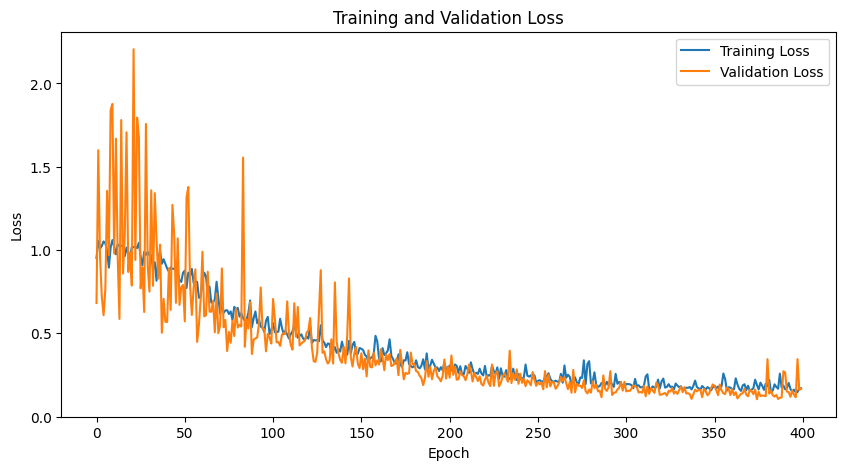

In [26]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
model.evaluate(test_dataset)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1462 - mean_squared_error: 0.1461

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1356 - mean_squared_error: 0.1356 


[0.13427777588367462, 0.1342698186635971]

In [31]:
model.save(os.path.join(os.path.dirname(os.getcwd()), 'models','avg_ratio_lstm_model.keras'))

## model with more layers

In [21]:

model_larger = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[20,8]),
    tf.keras.layers.LSTM(256, activation='tanh',return_sequences=True),
    tf.keras.layers.LSTM(128, activation='tanh',return_sequences=True),
    tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True),
    tf.keras.layers.LSTM(32, activation='tanh',return_sequences=False, ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


In [22]:
model_larger.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [23]:
model_larger.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 256)        │       271,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,337 (2.02 MB)

 Trainable params: 530,337 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 400

In [25]:
history = model_larger.fit(
    train_dataset,  
    validation_data=val_dataset, 
    epochs=epochs
)

Epoch 1/400


I0000 00:00:1732476304.860771  189022 cuda_dnn.cc:529] Loaded cuDNN version 90300


244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.9066 - mean_squared_error: 0.9066 - val_loss: 0.4464 - val_mean_squared_error: 0.4465
Epoch 2/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8282 - mean_squared_error: 0.8280 - val_loss: 1.1728 - val_mean_squared_error: 1.1727
Epoch 3/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0129 - mean_squared_error: 1.0128 - val_loss: 0.6209 - val_mean_squared_error: 0.6209
Epoch 4/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9406 - mean_squared_error: 0.9406 - val_loss: 0.9186 - val_mean_squared_error: 0.9185
Epoch 5/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4177 - mean_squared_error: 1.4170 - val_loss: 1.9194 - val_mean_squared_error: 1.9187
Epoch 6/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.2467 - mean_squared_error: 1.2466 - val_loss: 1.0706 - val_mean_squared_error: 1.0705
Epoch 7/400
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9521 - mean_squared_error: 0.9520 - val_loss: 0.

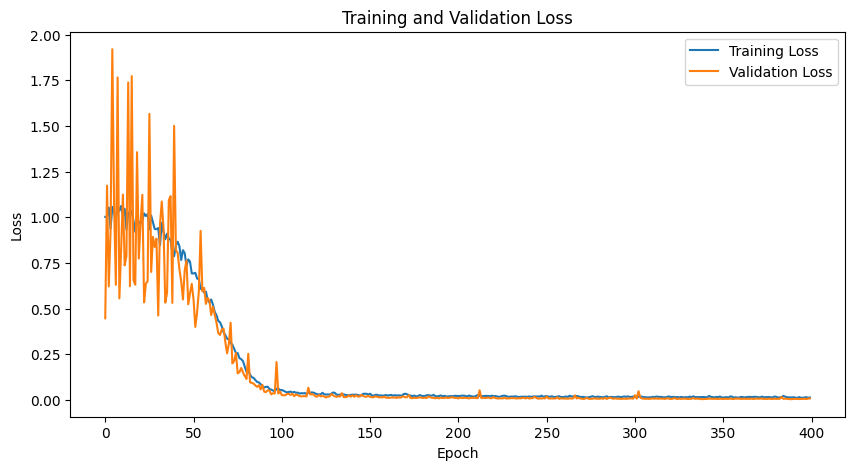

In [26]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
model_larger.evaluate(test_dataset)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0032 - mean_squared_error: 0.0032

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mean_squared_error: 0.0070 


[0.006332829128950834, 0.0063287378288805485]

In [29]:
model_larger.save(os.path.join(os.path.dirname(os.getcwd()), 'models','avg_ratio_lstm_larger_model.keras'))